In [1]:
using MLPipe

    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /Users/johnbonihalab/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /Users/johnbonihalab/.julia/v0.4/DataArrays/src/operators.jl:276.
To fix, define 
    +(DataArrays.DataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /Users/johnbonihalab/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.AbstractDataArray, AbstractArray) at /Users/johnbonihalab/.julia/v0.4/DataArrays/src/operators.jl:300.
To fix, define 
    +(DataArrays.AbstractDataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.


In [2]:
using MLBase
using Lazy
using PyCall
using RDatasets

### Load And Inspect Data

In [3]:
iris = dataset("datasets", "iris");
head(iris)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


#### Split Into Validation and Data Sets

In [4]:
validation_set, data_set = begin
    num_subjects = size(iris, 1)
    validation_ixs = 1:5:num_subjects
    data_ixs = setdiff(1:num_subjects, validation_ixs)
    
    iris[validation_ixs, :], iris[data_ixs, :]
end

@> validation_set size println
@> data_set size println

(30,5)
(120,5)


## See If Data Is Linearly Seperable

Linear models produce coefficients that are directly interpretable

#### calcAnova vs calcCorrelations

Use `calcAnova` to analyze correlations between predictors and a __categorical__ prediction outcome.

Use `calcCorrelations` to analyze correlations between predictors and a __continuous__ prediction outcome.

In [5]:
predictor_cols = names(data_set)[1:4]
corrs = calcAnova(data_set, names(data_set)[1:4], :Species)

Dict{Symbol,MLPipe.AnovaInfo} with 4 entries:
  :PetalWidth  => Groups Info…
  :SepalWidth  => Groups Info…
  :PetalLength => Groups Info…
  :SepalLength => Groups Info…

In [6]:
#Usually Just f-stat and p-value is enough
#If p-value is low (f-stat is high), indicates strong correlation

for (pred, ai) in corrs
    println(pred)
    fstat = ai.results_info[:FStat] |> dropna |> first
    pvalue = ai.results_info[:PValue] |> dropna |> first
    println("F-Stat: $fstat, P-Value: $pvalue")
    println()
end

PetalWidth
F-Stat: 757.65569739458, P-Value: 1.0962173966732075e-67

SepalWidth
F-Stat: 42.965327135118436, P-Value: 1.0210219072836324e-14

PetalLength
F-Stat: 876.423642465918, P-Value: 3.874483668862918e-71

SepalLength
F-Stat: 92.147407024539, P-Value: 9.286691162504962e-25



#### Low P-value's and high F-stats indicate separability. 

More detail can also be viewed for each predictor

In [7]:
pred = :PetalWidth
ai = corrs[pred]
println("#####")
println("$pred: Groups Info")
println(ai.groups_info)
println()
println("$pred: Anova Results")
println(ai.results_info)
println()
println("$pred: Tukey Analysis")
println(tukey(ai))
println("#####")

#####
PetalWidth: Groups Info
3×4 DataFrames.DataFrame
│ Row │ label        │ n  │ mean   │ stdError  │
├─────┼──────────────┼────┼────────┼───────────┤
│ 1   │ "setosa"     │ 40 │ 0.2425 │ 0.0175    │
│ 2   │ "versicolor" │ 40 │ 1.3225 │ 0.0300614 │
│ 3   │ "virginica"  │ 40 │ 1.985  │ 0.0430489 │

PetalWidth: Anova Results
3×5 DataFrames.DataFrame
│ Row │ source          │ df  │ sum_squares │ FStat   │ PValue      │
├─────┼─────────────────┼─────┼─────────────┼─────────┼─────────────┤
│ 1   │ "Within Group"  │ 117 │ 4.7785      │ 757.656 │ 1.09622e-67 │
│ 2   │ "Between Group" │ 2   │ 61.8882     │ NA      │ NA          │
│ 3   │ "Total"         │ 119 │ 66.6667     │ NA      │ NA          │

PetalWidth: Tukey Analysis
3×4 DataFrames.DataFrame
│ Row │ left         │ right        │ q       │ pval        │
├─────┼──────────────┼──────────────┼─────────┼─────────────┤
│ 1   │ "versicolor" │ "setosa"     │ 33.7988 │ 1.64762e-62 │
│ 2   │ "virginica"  │ "setosa"     │ 54.5318 │ 2.4804e-85 

## Create Pipeline

In [8]:
svc = begin
    @pyimport sklearn.svm as svm
    svm.LinearSVC()
end

function pipelineGen(data_set = data_set)
    #dictionary to hold model state during processing
    #updated over range of Cs by evalModel, will be clear shortly
    model_state = Dict(:svc_C => 1.)

    #fit functions
    fits = begin
        getXy(ixs) = (Matrix(data_set[ixs, predictor_cols]), Vector(data_set[ixs, :Species]))

        function svcFit!(Xy)
            X, y= Xy
            svc[:C] = model_state[:svc_C]
            svc[:fit](X, y)
        end

        [getXy, svcFit!]
    end

    #predict functions
    predicts = begin
        getX(ixs) = Matrix(data_set[ixs, predictor_cols])

        _pyArrayToJl(arr) = ASCIIString[p for p in arr]

        svcPredict(X) = svc[:predict](X) |> _pyArrayToJl

        [getX, svcPredict]
    end


    truths = data_set[:Species] |> Vector{ASCIIString}

    ###Create Pipeline
    Pipeline(fits, predicts, f1score, truths, model_state)
end

pipelineGen (generic function with 2 methods)

In [9]:
pipeline = pipelineGen()

MLPipe.Pipeline([getXy,svcFit!],[getX,svcPredict],MLBase.f1score,ASCIIString["setosa","setosa","setosa","setosa","setosa","setosa","setosa","setosa","setosa","setosa"  …  "virginica","virginica","virginica","virginica","virginica","virginica","virginica","virginica","virginica","virginica"],paramState,paramState!)

## Evaluate Model By Analyzing Train-Test Scores

In [10]:
cvg = StratifiedRandomSub(pipeline.truths, round(Int64, length(pipeline.truths)*.8), 10)

MLBase.StratifiedRandomSub([[1,2,3,4,5,6,7,8,9,10  …  31,32,33,34,35,36,37,38,39,40],[41,42,43,44,45,46,47,48,49,50  …  71,72,73,74,75,76,77,78,79,80],[81,82,83,84,85,86,87,88,89,90  …  111,112,113,114,115,116,117,118,119,120]],96,[32,32,32,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],10)

In [11]:
agg = meanTrainTest
model_eval = evalModel(pipeline, cvg, length(pipeline.truths), agg, 
    :svc_C => [1e-3, 5e-3, 1e-2, .1, 1, 10, 50, 1e2, 5e2])

([0.5555555555555555,0.5690802764486975,0.6408897641997221,0.9508675607005583,0.9541478234862352,0.9539290419274824,0.9284331881004256,0.9147593808344825,0.8808510420712226],[0.5555555555555555,0.5723027375201288,0.6141706924315621,0.9664363523187053,0.9663694366635542,0.9089171122994651,0.9217223222876744,0.9016783150916277,0.9071844701566063],[Dict{Symbol,Any}(:svc_C=>0.001),Dict{Symbol,Any}(:svc_C=>0.005),Dict{Symbol,Any}(:svc_C=>0.01),Dict{Symbol,Any}(:svc_C=>0.1),Dict{Symbol,Any}(:svc_C=>1.0),Dict{Symbol,Any}(:svc_C=>10.0),Dict{Symbol,Any}(:svc_C=>50.0),Dict{Symbol,Any}(:svc_C=>100.0),Dict{Symbol,Any}(:svc_C=>500.0)])

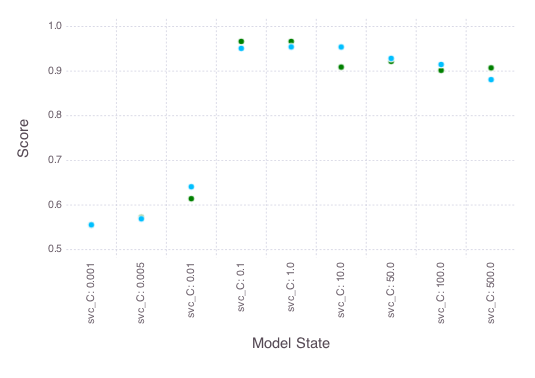

In [12]:
plotEvalModel(model_eval)

### Somewhere Around C=1 looks good

In [13]:
validation_pipeline = pipelineGen(iris)

Fontconfig warning: ignoring UTF-8: not a valid region tag


MLPipe.Pipeline([getXy,svcFit!],[getX,svcPredict],MLBase.f1score,ASCIIString["setosa","setosa","setosa","setosa","setosa","setosa","setosa","setosa","setosa","setosa"  …  "virginica","virginica","virginica","virginica","virginica","virginica","virginica","virginica","virginica","virginica"],paramState,paramState!)

In [14]:
#ensure svc_C is set to 1
paramState!(validation_pipeline, :svc_C => 1.)

1.0

In [15]:
pipeFit!(validation_pipeline, data_ixs)

PyObject LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [16]:
pipeTest(validation_pipeline, validation_ixs)

0.9326599326599325